In [8]:
import pyspark as ps
from pyspark.ml.feature import VectorAssembler, PCA
from pyspark.ml.clustering import KMeans
from pyspark.sql.functions import udf

import pandas as pd
import numpy as np
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE

In [57]:
import plotly
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, plot, iplot

In [2]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.axes_grid.anchored_artists import AnchoredText
mpl.rcParams.update({
    'font.size'           : 16.0,
    'axes.titlesize'      : 'large',
    'axes.labelsize'      : 'medium',
    'xtick.labelsize'     : 'small',
    'ytick.labelsize'     : 'small',
    'legend.fontsize'     : 'small',})
%matplotlib inline

In [3]:
spark = ps.sql.SparkSession.builder \
            .master("local[7]") \
            .appName("minhash") \
            .getOrCreate()            

sc = spark.sparkContext  # for the pre-2.0 sparkContext

In [4]:
# full_df = spark.read.csv('../data/npidata_20050523-20170813_clean_dont_overwrite.csv', \
#                      header=True, inferSchema=True)
full_df = spark.read.csv('s3n://gschoolcapstone/npidata_20050523-20170813_clean.csv', \
                    header=True, inferSchema=True)

In [5]:
cdf = full_df.sample(withReplacement=False, fraction=.005, seed=1234)
cdf.count()

25981

In [29]:
feature_cols = cdf.columns[1:]
va = VectorAssembler(inputCols=feature_cols, outputCol='features')
vdf = va.transform(cdf)

In [30]:
kMeans = KMeans(k=30)
model = kMeans.fit(vdf)

In [105]:
# centroids = model.clusterCenters()

In [104]:
model.computeCost(vdf)
# Return the K-means cost 
# (sum of squared distances of points to their nearest center) 
# for this model on the given data.

115456.97651441443

In [ ]:
summary = model.summary
sizes = summary.clusterSizes

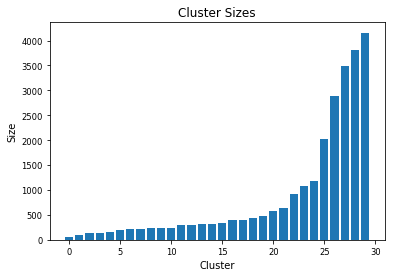

In [86]:
plt.title('Cluster Sizes')
plt.xlabel('Cluster')
plt.ylabel('Size')
plt.bar(range(30), sorted(sizes))
plt.savefig('cluster_sizes')

In [32]:
labels = model.transform(vdf).select('NPI','prediction').toPandas()

In [ ]:
# silhouette_score(distances, labels)

In [14]:
cdf[cdf.columns[1:]].toPandas().shape

(25981, 938)

In [20]:
feature_mat = cdf[cdf.columns[1:]].toPandas()

In [41]:
two_dim = TSNE(n_components=3, perplexity=30.0, early_exaggeration=12.0, learning_rate=200.0, n_iter=1000, \
                  n_iter_without_progress=300, min_grad_norm=1e-07, metric='jaccard')

In [42]:
X = two_dim.fit_transform(feature_mat.values)
X.shape

(25981, 3)

In [80]:
def make_3d_plot(M, labels):
    x = M[:,0].flatten()
    y = M[:,1].flatten()
    z = M[:,2].flatten()
    trace1 = go.Scatter3d(x=x, y=y, z=z, mode='markers',
                            marker=dict(size=5, color=labels, colorscale='Portland', opacity=0.6))
    data = [trace1]
    layout = go.Layout(margin=dict(l=0, r=0, b=0, t=0))
    fig = go.Figure(data=data, layout=layout)
#     plot(fig, filename='3d-plot-clusters.html')
    return plotly.offline.plot(data, auto_open=False, filename='clusters.html', show_link=False)

In [81]:
make_3d_plot(X, labels.values[:,1])

'file:///Users/christinebuckler/galvanize/provider-prescriber/src/clusters.html'

In [86]:
# df.select('NPI', 'prediction', 'dim1', 'dim2', 'dim3').write.csv('clusters_pca.csv', header=True, mode='overwrite')